In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet101
import torch
import torch.functional as F
import numpy as np
import requests
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from datasets import load_dataset

In [4]:
dataset = load_dataset("cats_vs_dogs", revision="main")

image = np.array(dataset["train"]["image"][2])
# image_url = "https://media.istockphoto.com/id/148421596/photo/traffic-jam-with-rows-of-cars.jpg?b=1&s=170667a&w=0&k=20&c=d5yhG3ocyntlfPYEVK_vcf6TOiKQ8k8xwkTrqsQikDE="
# image = np.array(Image.open('./data/cat.6.jpg'))
# image = np.array(Image.open(requests.get(image_url, stream=True).raw))
rgb_img = np.float32(image) / 255
image_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
# Taken from the torchvision tutorial
# https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html
model = deeplabv3_resnet101(pretrained=True, progress=False)
model = model.eval()

class SegmentationModelOutputWrapper(torch.nn.Module):
  def __init__(self, model): 
    super(SegmentationModelOutputWrapper, self).__init__()
    self.model = model
        
  def forward(self, x):
    return self.model(x)["out"]

model = SegmentationModelOutputWrapper(model)

out = model(image_tensor)

Found cached dataset cats_vs_dogs (/home/amir/.cache/huggingface/datasets/cats_vs_dogs/default/1.0.0/d4fe9cf31b294ed8639aa58f7d8ee13fe189011837038ed9a774fde19a911fcb)
100%|██████████| 1/1 [00:00<00:00, 509.08it/s]
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


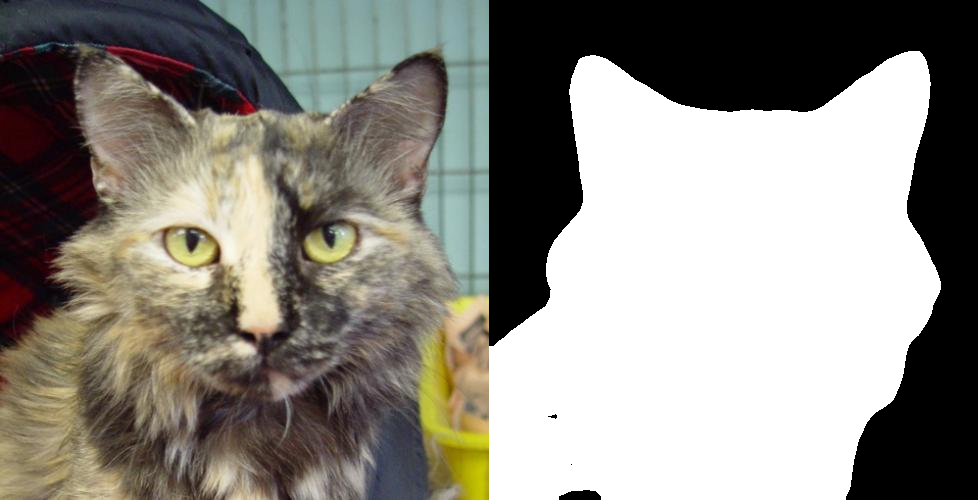

In [6]:
normalized_masks = torch.nn.functional.softmax(out, dim=1).cpu()
sem_classes = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

car_category = sem_class_to_idx["cat"]
car_mask = normalized_masks[0, :, :, :].argmax(axis=0).detach().cpu().numpy()
car_mask_uint8 = 255 * np.uint8(car_mask == car_category)
car_mask_float = np.float32(car_mask == car_category)

both_images = np.hstack((image, np.repeat(car_mask_uint8[:, :, None], 3, axis=-1)))
Image.fromarray(both_images)

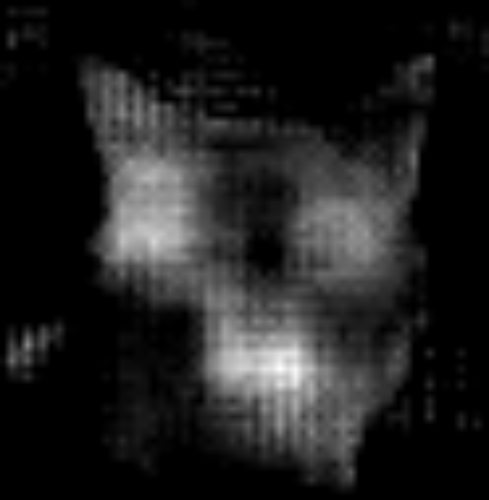

In [14]:
from pytorch_grad_cam import GradCAM

class SemanticSegmentationTarget:
  def __init__(self, category, mask):
    self.category = category
    self.mask = torch.from_numpy(mask)
    if torch.cuda.is_available():
      self.mask = self.mask.cuda()
        
  def __call__(self, model_output):
    return (model_output[self.category, :, : ] * self.mask).sum()

    
target_layers = [model.model.backbone.layer4]
targets = [SemanticSegmentationTarget(car_category, car_mask_float)]
with GradCAM(model=model, target_layers=target_layers,use_cuda=torch.cuda.is_available()) as cam:
  grayscale_cam = cam(input_tensor=image_tensor,targets=targets)[0, :]
  cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(np.uint8(grayscale_cam * 255) , 'L')

In [12]:
model.model.backbone.layer4

IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1